In [3]:
import pandas as pd

data = pd.read_csv('data_sample_one_year.csv')

data = data.iloc[:, [0,3]]
data.rename(columns={'high':'close'}, inplace=True)

from talib import RSI
data['rsi'] = RSI(data['close'])

data['shift'] = data.rsi.shift(1)
data.dropna(axis=0, inplace=True)

data['up'] = data['rsi'] > data['shift']

In [4]:
data

,timestamp,close,rsi,shift,up
15,1675868400,1651.57,35.387550,43.483899,False
16,1675879200,1641.08,29.150096,35.387550,False
17,1675882800,1642.42,30.827374,29.150096,True
18,1675886400,1636.22,27.574649,30.827374,False
19,1675890000,1640.28,32.590569,27.574649,True
...,...,...,...,...,...
8092,1707336000,2418.66,79.801442,78.251347,True
8093,1707339600,2424.86,81.156058,79.801442,True
8094,1707343200,2421.03,77.689871,81.156058,False
8095,1707346800,2421.81,77.896916,77.689871,True


In [5]:
states_trade = {'offtrade': 0, 'long': 1, 'short': 2}
states_cumulative = {'neutral': 0, 'positive': 1, 'negative': 2}
states_global = {'neutral': 0, 'profit': 1, 'loss': 2}

import itertools

state_space = []
for combo in itertools.product(states_trade.values(), states_cumulative.values(), states_global.values()):
    state_space.append(combo)

actions = {'hold': 0, 'buy': 1, 'sell': 2}
action_space = [i for i in actions.values()]

# my q-learning agent

In [12]:
import numpy as np

class MyQLearningAgent:
    def __init__(self, data, states, actions, alpha=0.3, gamma=0.7, epsilon=0.3):
        self.data = data
        
        self.states = states
        self.actions = actions
        self.pseudo_actions = []
        
        self.num_states = len(states)
        self.num_actions = len(actions)
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = np.zeros((self.num_states, self.num_actions))

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(self.actions)
        else:
            return self.actions[np.argmax(self.Q[self.states.index(state)])]

    def update_q_table(self, state, action, reward, next_state):
        self.Q[self.states.index(state), self.actions.index(action)] += self.alpha * (
                reward + self.gamma * np.max(self.Q[self.states.index(next_state)]) -
                self.Q[self.states.index(state), self.actions.index(action)])

    def train(self, num_episodes):
        for episode in range(num_episodes):
            total_reward = 0
            state = [0, 0, 0]
            price_recent = []

            for i in range(1, len(self.data)):
                price_open = self.data['close'].iloc[i] # position open price
                price_recent.append(1) if self.data['close'].iloc[i-1] > price_open else price_recent.append(0)

                if price_recent.count(1) > price_recent.count(0):
                    state[1] = 1
                else:
                    state[1] = 2
                
                if state[0] == 0:
                    self.pseudo_actions = [1, 2]
                elif state[0] == 1:
                    self.pseudo_actions = [0, 2]
                elif state[0] == 2:
                    self.pseudo_actions = [0, 1]

                j = i+1
                while j < len(self.data):
                    action = None
                    while not action in self.pseudo_actions:
                        action = self.choose_action(tuple(state))

                    delta_t = j - i

                    if action == 1:
                        price_delta = self.data['close'].iloc[j] - price_open
                        price_recent.append(1) if self.data['close'].iloc[j] > self.data['close'].iloc[j-1] else price_recent.append(0)
                        
                        reward = self.get_reward(tuple(state), action, self.data, i, j)

                        if price_delta > 0:
                            next_state = [ state[0], state[1], 1]
                        elif price_delta < 0:
                            next_state = [ state[0], state[1], 2]
                        else:
                            next_state = [ state[0], state[1], 0]

                        if price_recent.count(1) > price_recent.count(0):
                            next_state = [ state[0], 1, next_state[2]]
                        else:
                            next_state = [ state[0], 2, next_state[2]]
                        
                        if state[0] == 0:
                            next_state = [ 1, next_state[1], next_state[2]]
                        elif state[0] == 2:
                            next_state = [ 0, next_state[1], next_state[2]]

                        self.update_q_table(tuple(state), action, reward, tuple(next_state))
                        state = next_state

                    elif action == 2:
                        price_delta = self.data['close'].iloc[j] - price_open
                        price_recent.append(1) if self.data['close'].iloc[j] > self.data['close'].iloc[j-1] else price_recent.append(0)

                        reward = self.get_reward(tuple(state), action, self.data, i, j)

                        if price_delta > 0:
                            next_state = [ state[0], state[1], 1]
                        elif price_delta < 0:
                            next_state = [ state[0], state[1], 2]
                        else:
                            next_state = [ state[0], state[1], 0]

                        if price_recent.count(1) > price_recent.count(0):
                            next_state = [ state[0], 1, next_state[2]]
                        else:
                            next_state = [ state[0], 2, next_state[2]]
                        
                        if state[0] == 0:
                            next_state = [ 2, next_state[1], next_state[2]]
                        elif state[0] == 1:
                            next_state = [ 0, next_state[1], next_state[2]]

                        self.update_q_table(tuple(state), action, reward, tuple(next_state))
                        state = next_state

                    elif action == 0:
                        price_delta = self.data['close'].iloc[j] - price_open
                        price_recent.append(1) if self.data['close'].iloc[j] > self.data['close'].iloc[j-1] else price_recent.append(0)

                        reward = self.get_reward(tuple(state), action, self.data, i, j)

                        if price_delta > 0:
                            next_state = [ state[0], state[1], 1]
                        elif price_delta < 0:
                            next_state = [ state[0], state[1], 2]
                        else:
                            next_state = [ state[0], state[1], 0]

                        if price_recent.count(1) > price_recent.count(0):
                            next_state = [ state[0], 1, next_state[2]]
                        else:
                            next_state = [ state[0], 2, next_state[2]]
                        
                        if state[0] == 1:
                            next_state = [ state[0], next_state[1], next_state[2]]
                        elif state[0] == 2:
                            next_state = [ state[0], next_state[1], next_state[2]]

                        self.update_q_table(tuple(state), action, reward, tuple(next_state))
                        state = next_state

                    j += 1
                    
                    # Check for terminal state
                    if state[0] == 0:
                        break

                total_reward += reward

            print("Episode {}: Total Reward = {}".format(episode + 1, total_reward))
            # ---------------------------------------------------
    
    def get_reward(self, state, action, data, i, j):

        if state[0] == 1:
            return MyQLearningAgent.get_score(data, i, j)
        elif state[0] == 2:
            return -MyQLearningAgent.get_score(data, i, j)
        else:
            return 0

    @staticmethod
    def one_score(price_0, price_1, delta_t, rsi_0, rsi_1):
        from scipy.stats import norm
    
        nd = norm(loc=rsi_0, scale=1)
    
        return (price_1 - price_0) * (nd.cdf(rsi_0) - nd.cdf(rsi_1)) * np.log(delta_t + np.e) / price_0

    @staticmethod
    def get_score(data, i, j):
        score = 0
        for k in range(j-i-1):
            score += MyQLearningAgent.one_score(data['close'].iloc[k], data['close'].iloc[k+1], i+k, data['rsi'].iloc[k], data['rsi'].iloc[k+1])
    
        return score * 100

In [7]:
my_list = []

for i in range(30):
    my_list.append(MyQLearningAgent.get_score(data, 0, i))

In [8]:
my_list

[0,
 0,
 -0.3175766087823886,
 -0.3661803662187038,
 -0.6586744417016464,
 -0.8750050662165461,
 -1.4742280890188049,
 -2.009083052214125,
 -2.242253259114025,
 -2.5351727388176553,
 -3.8421079751768596,
 -5.611536712976599,
 -5.757621983825185,
 -7.005867376629607,
 -7.328852980555174,
 -7.339854037209255,
 -7.340648022432711,
 -7.340707222029182,
 -7.751071707229307,
 -8.524229578393088,
 -8.59469606215063,
 -9.262983939269173,
 -10.321945719559235,
 -10.36628210018936,
 -10.779930103221247,
 -16.34026257810609,
 -20.804666942942085,
 -21.20611556588657,
 -22.35256477025941,
 -22.90736945199733]

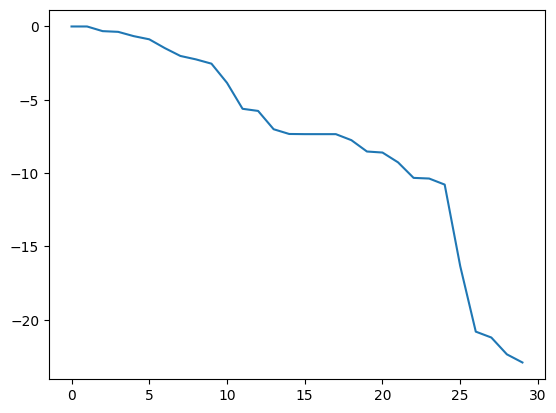

In [9]:
import matplotlib.pyplot as plt

plt.plot(my_list)
plt.show()

<Axes: >

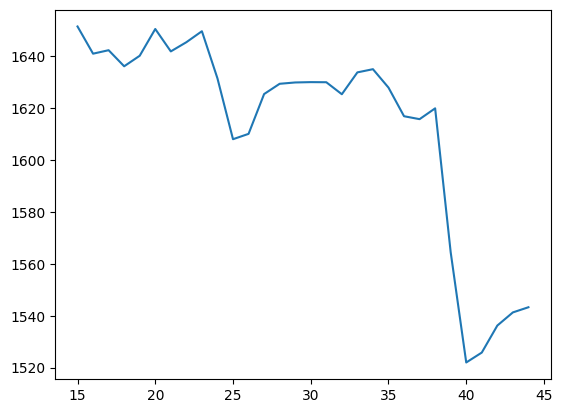

In [10]:
data['close'].iloc[:30].plot()

In [13]:
agent = MyQLearningAgent(data, state_space, action_space)
agent.train(num_episodes=3)

KeyboardInterrupt: 

In [14]:
agent.Q

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  6.13329132,  0.        ],
       [ 0.        ,  8.46100795, 15.84030149],
       [ 0.        ,  8.60532457, 26.395573  ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  3.70157493],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  4.3726531 ,  0.        ],
       [ 0.        ,  6.38240079, 12.9222356 ],
       [ 0.        ,  6.01197979, 14.4593133 ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.45860543],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.   